## Implementing Neural Network

In this notebook, I want to implement a neural network from scratch to understand its architecture. I will implement a simple one layer neural network with two units. 

Here is how the network will look like (of course, we will be dealing with more inputs!).

<img src="img/implementing_nnetwork/one_hidden_layer.png" width="300px">

In [226]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [10]:
mnist = datasets.load_digits()

In [50]:
data = mnist.data
targets = mnist.target

In [52]:
data.shape

(1797, 64)

In [49]:
def image_standarization(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x_demean = x - np.mean(x)
    adjusted_sd = np.maximum(np.std(x), 1.0/np.sqrt(np.prod(x.shape)))
    return  x_demean / adjusted_sd

In [54]:
#Standardizing data
data = np.apply_along_axis(image_standarization, 1, data)

In [58]:
#One hot encoding data
encoder = LabelBinarizer()
encoder.fit(targets)
targets = encoder.transform(targets)

In [60]:
#Separating train / test / validation
image, image_test, y, y_test = train_test_split(data, targets, test_size=0.2, train_size=0.8)
image_train, image_val, y_train, y_val = train_test_split(image, y,test_size = 0.25, train_size =0.75)

### Creating useful functions for out network

In [211]:
def gen_weights(input_size, output_size):
    "Generates weights for different units"
    return  np.random.uniform(size=(input_size, output_size))

In [22]:
def apply_relu(matrix):
    "Applies relu to matrix"
    return np.maximum(0, matrix)

In [96]:
def apply_softmax(matrix):
    exp = np.exp(matrix) 
    soft_max = exp / np.sum(exp, axis=1, keepdims=True)
    return soft_max

In [61]:
def d_apply_softmax(soft_res, n_training):
    soft_res[range(n_training), np.argmax(y_train, axis=1)] -= 1
    return soft_res

## Building the neural network

Our neural network will have two activation functions. First we will generate a matrix multiplication between inputs and first layer and, then, we will apply a ReLU. Then, after the ReLU we will further apply weights and a softmax layers that will produce the probabilities of each of the 10 labels that we are trying to predict.

In [62]:
image_train.shape

(1077, 64)

In [219]:
n_training = len(image_train)
n_classes = 10
step_size = 0.0001
epochs = 50000

#Creating forward pass
bias_1 = np.zeros((1,20))
bias_2 = np.zeros((1,20))
W1 = gen_weights(64, 20) 
W2 = gen_weights(64, 20)  
W3 = gen_weights(20,10)
W4 = gen_weights(20,10)

for e in range(epochs): 
    W1 = W1 + bias_1
    W2 = W2 + bias_2
    h1 = image_train.dot(W1)
    h2 = image_train.dot(W2)
    relu_1 = apply_relu(h1)
    relu_2 = apply_relu(h2)
    h3 = relu_1.dot(W3) + relu_2.dot(W4) # Make final class a weighted average of the two units
    out_soft = apply_softmax(h3)
    
    
    #Calculate Loss
    correct_labels_prob = out_soft[range(n_training), np.argmax(y_train, axis=1)]
    loss = np.sum(-np.log(correct_labels_prob)) / n_training
    
    if e%1000==0:
        print("Los: {}".format(loss))
    
    ## Backpropagation
    
    #Calculating gradient
    g_probs = np.copy(out_soft)
    g_probs[range(n_training), np.argmax(y_train, axis=1)] -= 1
    
    #Get the average of the gradients
    g_probs = g_probs / n_training
    
    #Calculating gradients for W3 and W4
    dW3 = relu_1.T.dot(g_probs)
    dW4 = relu_2.T.dot(g_probs)
    
    #Calculating hidden gradients
    dhidden1 = np.dot(g_probs, W3.T)
    dhidden2 = np.dot(g_probs, W4.T)
    
    #Calculating gradients for ReLU's
    dhidden1[relu_1 <= 0] = 0
    dhidden2[relu_2 <= 0] = 0
    #
    ##Calculating gradients for initial weights
    dW1 = image_train.T.dot(dhidden1)
    db1 = np.sum(dhidden1, axis=0, keepdims=True)
    #
    dW2 = image_train.T.dot(dhidden2)
    db2 = np.sum(dhidden2, axis=0, keepdims=True)
    #
    ##Updating weights
    W3 += -step_size*dW3
    W4 += -step_size*dW4
    #
    W1 += -step_size*dW1
    bias_1 += -step_size*db1
    W2 += -step_size*dW2
    bias_2 += -step_size*db2

    #Test Validation Accuracy   
    h1_val = image_val.dot(W1)
    h2_val = image_val.dot(W2)
    relu_1_val = apply_relu(h1_val)
    relu_2_val = apply_relu(h2_val)
    h3_val = relu_1_val.dot(W3) + relu_2_val.dot(W4) # Make final class a weighted average of the two units
    preds_score = apply_softmax(h3_val)
    pred_ones = np.zeros_like(preds_score) #generates zero matrix to populate them with ones to then make comparisons
    pred_ones[np.arange(len(preds_score)), preds_score.argmax(1)] = 1
    accuracy = np.mean(np.equal(pred_ones, y_val).all(axis=1))

    if e%1000==0:
        print("Validation Accuracy: {}".format(accuracy))
    



Los: 4.239157783364263
Validation Accuracy: 0.075
Los: 3.2034464321275826
Validation Accuracy: 0.12777777777777777
Los: 2.654334768442389
Validation Accuracy: 0.16666666666666666
Los: 2.2939548171525765
Validation Accuracy: 0.21666666666666667
Los: 2.0380730812754115
Validation Accuracy: 0.28888888888888886
Los: 1.8381907358836802
Validation Accuracy: 0.3333333333333333
Los: 1.6728935352344536
Validation Accuracy: 0.4
Los: 1.5338131071635241
Validation Accuracy: 0.46944444444444444
Los: 1.4142932849557925
Validation Accuracy: 0.5027777777777778
Los: 1.3111038108836983
Validation Accuracy: 0.5444444444444444
Los: 1.221484669043867
Validation Accuracy: 0.5777777777777777
Los: 1.1429271816205424
Validation Accuracy: 0.6083333333333333
Los: 1.0738750012203897
Validation Accuracy: 0.6416666666666667
Los: 1.0127699563590753
Validation Accuracy: 0.6638888888888889
Los: 0.9584886840384986
Validation Accuracy: 0.6916666666666667
Los: 0.9098117906058133
Validation Accuracy: 0.7111111111111111
Lo

In [221]:
#Getting testing accuracy
#Testing predictions on testing data set
#Test Validation Accuracy   
h1_test = image_test.dot(W1)
h2_test = image_test.dot(W2)
relu_1_test = apply_relu(h1_test)
relu_2_test = apply_relu(h2_test)
h3_test = relu_1_test.dot(W3) + relu_2_test.dot(W4) # Make final class a weighted average of the two units
preds_score = apply_softmax(h3_test)
pred_ones = np.zeros_like(preds_score) #generates zero matrix to populate them with ones to then make comparisons
pred_ones[np.arange(len(preds_score)), preds_score.argmax(1)] = 1
accuracy = np.mean(np.equal(pred_ones, y_test).all(axis=1))
print("Testing Accuracy: {}".format(accuracy))

Testing Accuracy: 0.8916666666666667


## Checking with one specific image

6


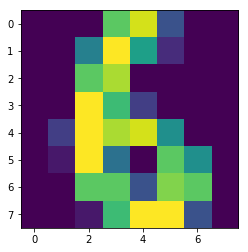

In [237]:
print(np.argmax(y_test[10]))
plt.imshow(image_test[10].reshape(8,8))

In [240]:
h1_test = image_test[10].dot(W1)
h2_test = image_test[10].dot(W2)
relu_1_test = apply_relu(h1_test)
relu_2_test = apply_relu(h2_test)
h3_test = relu_1_test.dot(W3) + relu_2_test.dot(W4) # Make final class a weighted average of the two units
exp = np.exp(h3_test) 
soft_max = exp / np.sum(exp, keepdims=True)
np.argmax(soft_max) ## Correctly guesses the number -> Assigns more probability to 6

6